In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from sklearn import preprocessing
from scipy.signal import savgol_filter
import math
from pandas.core.frame import DataFrame
import random

In [31]:
def read_csv(file_names):
    data_list = []
    for i in range(len(file_names)):
        for j in range(5):
            data_file = os.path.join('data', file_names[i] + '_' + str(j+1)+'.csv')
            locals()[file_names[i]+'_'+str(j+1)] = pd.read_csv(data_file)
            data_list.append([locals()[file_names[i]+'_'+str(j+1)],file_names[i]])
    return data_list

In [3]:
def filter_data(data_list):
    for i in range(20):
        for j in range(3):
            data_list[i][0].iloc[:,j] = savgol_filter(list(data_list[i][0].iloc[:,j]), 55, 2, mode= 'nearest')
    
    return data_list

In [4]:
def normalization(data_list):
    for i in range(20):
        for j in range(3):
            _range = data_list[i][0].iloc[:,j].max() - data_list[i][0].iloc[:,j].min()
            data_list[i][0].iloc[:,j] = (data_list[i][0].iloc[:,j] - data_list[i][0].iloc[:,j].min()) / _range
    
    return data_list

In [5]:
def show_img(file_names, data_list):
    fig = plt.figure(figsize=(16,16),dpi=300)
    index = 0
    for i in range(len(file_names)):
        for j in range(5):
            index = index + 1
            locals()['ax'+'_'+str(index)] = fig.add_subplot(10,2,index)
            for k in range(3): 
                x = range(len(data_list[index - 1][0].iloc[:,k]))
                y = data_list[index - 1][0].iloc[:,k]
                title = data_list[index - 1][1] + "_" + str(j + 1)
                locals()['ax'+'_'+str(index)].set_title(title)
                locals()['ax'+'_'+str(index)].plot(x, y)
    fig.legend(['Linear Acceleration x','Linear Acceleration y','Linear Acceleration z'],loc = 'upper right') 
    plt.tight_layout()
    plt.show()


In [6]:
def data_preprocessing(data_list):
    for data in data_list:
        data[0].drop(labels=['Time (s)', 'Absolute acceleration (m/s^2)'], axis=1, inplace = True)
        #number_del = int(data_list[0][0].shape[0]/13)
        data[0].drop(data[0].tail(100).index, inplace = True)
        data[0].drop(data[0].head(50).index, inplace = True)
        data[0] =  data[0].reset_index(drop=True)     

In [7]:
def data_cut(data_list):
    down_line = 0.4
    temp_list = []
    temp_list2 = []
    local_minimum = []
    cutting_data = []
    for i in range(len(data_list)):
        for j in range(len(data_list[i][0]) - 1):
            if(data_list[i][0].iloc[j,2] > 0.4 and data_list[i][0].iloc[j+1,2] < 0.4):
                temp_list.append(j)
        for k in range(len(temp_list) - 1):
            temp_list2.append(list(data_list[i][0].iloc[:,2]).index(min(list(data_list[i][0].iloc[:,2])[temp_list[k]:temp_list[k + 1]])))
        local_minimum.append(temp_list2)
        temp_list = []
        temp_list2 = []
    for i in range(len(local_minimum)):
        for j in range(len(local_minimum[i])-1):
            temp_list.append(list(data_list[i][0].iloc[:,0])[local_minimum[i][j]:local_minimum[i][j + 1]])
            temp_list.append(list(data_list[i][0].iloc[:,1])[local_minimum[i][j]:local_minimum[i][j + 1]])
            temp_list.append(list(data_list[i][0].iloc[:,2])[local_minimum[i][j]:local_minimum[i][j + 1]])
            cutting_data.append([temp_list, data_list[i][1]])
            temp_list = []
    for i in range(len(cutting_data)):
        if(len(cutting_data[i][0][0]) < 50):
            cutting_data.pop(i)
    for i in range(len(cutting_data)):
        if(len(cutting_data[i][0][0]) < 80):
            while(len(cutting_data[i][0][0]) != 80):
                random_index = random.randint(0, len(cutting_data[i][0][0])-2)
                cutting_data[i][0][0].insert(random_index+1, (cutting_data[i][0][0][random_index] + cutting_data[i][0][0][random_index + 1])/2)
                cutting_data[i][0][1].insert(random_index+1, (cutting_data[i][0][0][random_index] + cutting_data[i][0][0][random_index + 1])/2)
                cutting_data[i][0][2].insert(random_index+1, (cutting_data[i][0][0][random_index] + cutting_data[i][0][0][random_index + 1])/2)
        elif(len(cutting_data[i][0][0]) > 80):
            while(len(cutting_data[i][0][0]) != 80):
                random_index = random.randint(0, len(cutting_data[i][0][0])-2)
                cutting_data[i][0][0].pop(random_index) 
                cutting_data[i][0][1].pop(random_index) 
                cutting_data[i][0][2].pop(random_index) 
    return cutting_data

In [12]:
def data_transfer_list(data_list, label):
    image_list = []
    label_list = []
    tran_list = []
    tran1_list = []
    label_tran_list = []
    cutting_data = []
    cutting_data = data_cut(data_list)
    random_index = []
    for i in range(len(cutting_data)):
        for j in range(len(cutting_data)):
            if(cutting_data[i][1] == cutting_data[j][1] and i != j):
                tran_list = [cutting_data[i][0][0]+cutting_data[j][0][0],cutting_data[i][0][1]+cutting_data[j][0][1],cutting_data[i][0][2]+cutting_data[j][0][2]]
                tran1_list.append(tran_list)
                label_tran_list.append(cutting_data[i][1])
            tran_list = []
    for i in range(len(tran1_list)):
        for j in range(4):
            random_index.append(random.randint(0, len(cutting_data)-2))
        for j in random_index:
            if(label_tran_list[i] == cutting_data[j][1]):
                tran_list = [tran1_list[i][0]+cutting_data[j][0][0],tran1_list[i][1]+cutting_data[j][0][1],tran1_list[i][2]+cutting_data[j][0][2]]
                image_list.append(tran_list)
                label_list.append(label_tran_list[i])
            tran_list = []
        random_index = []
    label_encoder = preprocessing.LabelEncoder()
    label_list = list(label_encoder.fit_transform(label_list))
    return image_list, label_list

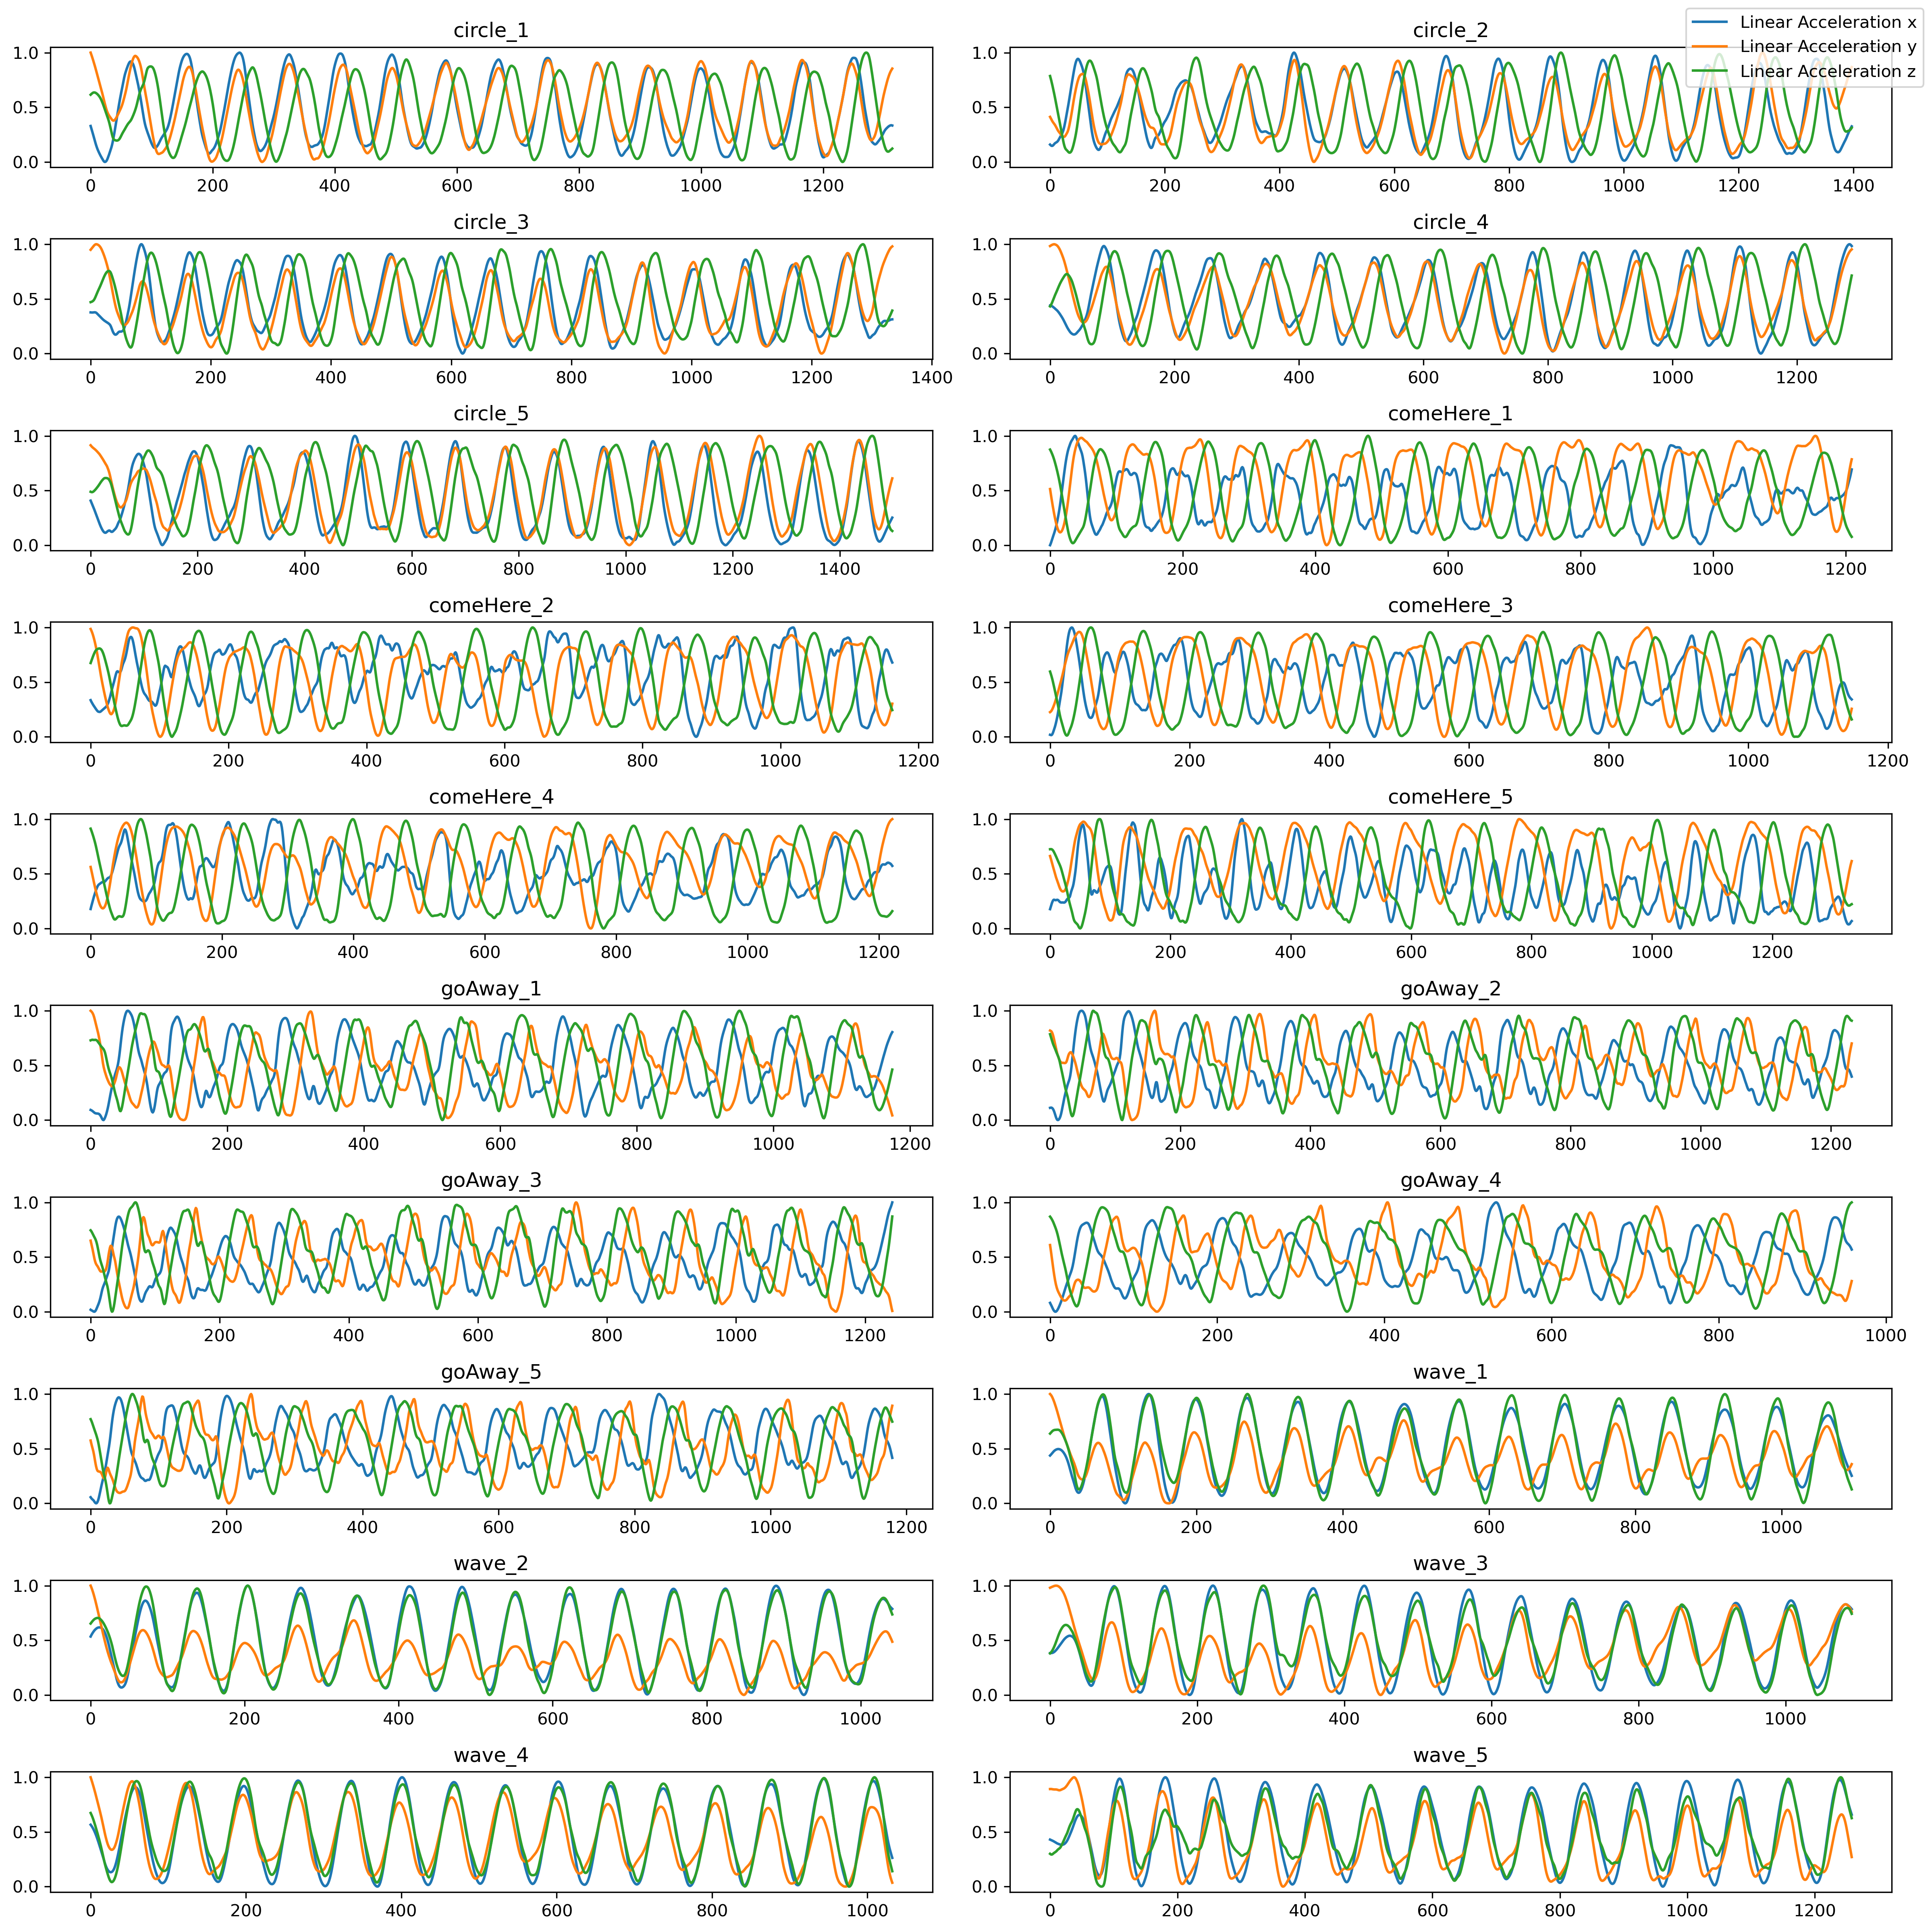

In [15]:
# file_names = ['circle', 'comeHere', 'goAway', 'wave']
# label = file_names
# data_list = []
# image_list = []
# label_list = []
# data_list = read_csv(file_names)
# data_preprocessing(data_list)
# # show_img(file_names, data_list)
# data_list = filter_data(data_list)
# data_list = normalization(data_list)
# show_img(file_names, data_list)

In [16]:
# image_list, label_list = data_transfer_list(data_list, label)

In [17]:
# X, y = torch.tensor(image_list), torch.tensor(label_list)
# X.shape, y.shape

(torch.Size([17109, 3, 240]), torch.Size([17109]))

In [27]:
# y = image_list[340][2][:]
# x = range(len(image_list[0][0][:]))
# plt.plot(x, y)